# `train_compare.log` 训练日志分析

本 notebook 用于解析并可视化多模态神经网络训练日志 `train_compare.log`，包括：
- 各模态的 loss / accuracy 随 epoch 变化曲线
- 由混淆矩阵计算的准确率和 balanced accuracy
- 每个类别的 precision / recall 随 epoch 变化
- 最优 epoch 等信息

> 使用前请确认本 notebook 与 `train_compare.log` 在同一目录下，或在下面的 `log_path` 中修改路径。

In [47]:
import re
from pathlib import Path

import numpy as np
import pandas as pd


In [48]:

import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

# 图像大小可以根据需要调整
plt.rcParams['figure.figsize'] = (6, 4)


In [49]:
# 日志路径（如不在同一目录，可以手动改成绝对路径或相对路径）
log_path = Path('train_compare.log')

assert log_path.exists(), f'Log file not found: {log_path}'

text = log_path.read_text(encoding='utf-8', errors='ignore')
print('Loaded log with', len(text.splitlines()), 'lines')

Loaded log with 229 lines


In [50]:
# 解析每个 epoch 的整体指标：train_loss / full/audio/sensor loss & acc
epoch_pattern = re.compile(
    r"Epoch\s+(\d+):\s*"  # epoch index
    r"train_loss=([0-9.]+)\s*\|\s*"
    r"full:\s*loss=([0-9.]+), acc=([0-9.]+)\s*\|\s*"
    r"audio_only:\s*loss=([0-9.]+), acc=([0-9.]+)\s*\|\s*"
    r"sensor_only:\s*loss=([0-9.]+), acc=([0-9.]+)"
)

rows = []
for m in epoch_pattern.finditer(text):
    epoch = int(m.group(1))
    rows.append(
        {
            'epoch': epoch,
            'train_loss': float(m.group(2)),
            'full_loss': float(m.group(3)),
            'full_acc': float(m.group(4)),
            'audio_loss': float(m.group(5)),
            'audio_acc': float(m.group(6)),
            'sensor_loss': float(m.group(7)),
            'sensor_acc': float(m.group(8)),
        }
    )

df_main = pd.DataFrame(rows).sort_values('epoch').reset_index(drop=True)
print('Parsed epochs:', len(df_main))
display(df_main.head())

Parsed epochs: 30


,epoch,train_loss,full_loss,full_acc,audio_loss,audio_acc,sensor_loss,sensor_acc
0,1,0.2397,2.0949,0.5063,2.0527,0.5063,0.6949,0.5021
1,2,0.0335,1.2082,0.7468,1.1678,0.7468,0.6965,0.5021
2,3,0.0211,1.5943,0.4979,1.5625,0.4937,0.6985,0.5021
3,4,0.0057,0.5963,0.7679,0.5907,0.7722,0.6989,0.5021
4,5,0.0085,1.5215,0.7511,1.4592,0.7511,0.6995,0.5021


In [51]:
# 解析每个 epoch 的混淆矩阵（2x2），格式类似：
# tensor([[ 34,  84],
#         [  0, 119]])

cm_pattern = re.compile(
    r"Epoch\s+(\d+):.*?"  # epoch index
    r"Confusion matrix .*?"  # 一直到混淆矩阵
    r"tensor\(\[\[\s*(\d+),\s*(\d+)\],\s*\[\s*(\d+),\s*(\d+)\]\]\)",
    re.S,
)

rows_cm = []
for m in cm_pattern.finditer(text):
    epoch = int(m.group(1))
    tn, fp, fn, tp = map(int, m.groups()[1:])
    rows_cm.append(
        {
            'epoch': epoch,
            'tn': tn,  # true no_secretion
            'fp': fp,  # predicted secretion but actually no_secretion
            'fn': fn,  # predicted no_secretion but actually secretion
            'tp': tp,  # true secretion
        }
    )

df_cm = pd.DataFrame(rows_cm).sort_values('epoch').reset_index(drop=True)
print('Parsed confusion matrices:', len(df_cm))
display(df_cm.head())

Parsed confusion matrices: 30


,epoch,tn,fp,fn,tp
0,1,1,117,0,119
1,2,59,59,1,118
2,3,59,59,60,59
3,4,95,23,32,87
4,5,59,59,0,119


In [52]:
# 解析每个 epoch 每个类别的 precision/recall
# 区块结构：
#   Per-class precision/recall:
#     no_secretion: precision=1.000, recall=0.288
#     secretion:    precision=0.586, recall=1.000

epoch_header_pattern = re.compile(r"Epoch\s+(\d+):")
matches = list(epoch_header_pattern.finditer(text))

rows_cls = []
for idx, m in enumerate(matches):
    epoch = int(m.group(1))
    start = m.start()
    end = matches[idx + 1].start() if idx + 1 < len(matches) else len(text)
    block = text[start:end]

    for line in block.splitlines():
        m2 = re.search(r"^\s*(\S+):\s*precision=([0-9.]+),\s*recall=([0-9.]+)", line)
        if m2:
            label = m2.group(1).strip("'\"")
            precision = float(m2.group(2))
            recall = float(m2.group(3))
            rows_cls.append(
                {
                    'epoch': epoch,
                    'label': label,
                    'precision': precision,
                    'recall': recall,
                }
            )

df_class = pd.DataFrame(rows_cls).sort_values(['label', 'epoch']).reset_index(drop=True)
print('Parsed class metrics rows:', len(df_class))
display(df_class.head())

if not df_class.empty:
    df_pivot_p = df_class.pivot(index='epoch', columns='label', values='precision')
    df_pivot_r = df_class.pivot(index='epoch', columns='label', values='recall')
    print('\nPrecision pivot:')
    display(df_pivot_p)
    print('\nRecall pivot:')
    display(df_pivot_r)

Parsed class metrics rows: 60


,epoch,label,precision,recall
0,1,no_secretion,1.000,0.008
1,2,no_secretion,0.983,0.500
2,3,no_secretion,0.496,0.500
3,4,no_secretion,0.748,0.805
4,5,no_secretion,1.000,0.500



Precision pivot:


label,no_secretion,secretion
epoch,,
1,1.000,0.504
2,0.983,0.667
3,0.496,0.500
4,0.748,0.791
5,1.000,0.669
6,1.000,0.669
7,1.000,0.538
8,0.661,0.899
9,0.671,0.766



Recall pivot:


label,no_secretion,secretion
epoch,,
1,0.008,1.000
2,0.500,0.992
3,0.500,0.496
4,0.805,0.731
5,0.500,1.000
6,0.500,1.000
7,0.136,1.000
8,0.941,0.521
9,0.814,0.605


In [53]:
# 基于混淆矩阵计算准确率 / 每类召回率 / balanced accuracy
if not df_cm.empty:
    # 与 df_main 对齐（以防某些 epoch 没有混淆矩阵或没有 main 记录）
    df_cm = df_cm.merge(df_main[['epoch']], on='epoch', how='right')
    for col in ['tn', 'fp', 'fn', 'tp']:
        if col in df_cm.columns:
            df_cm[col] = df_cm[col].fillna(0).astype(int)

    total = df_cm['tn'] + df_cm['fp'] + df_cm['fn'] + df_cm['tp']
    df_cm['acc_from_cm'] = (df_cm['tn'] + df_cm['tp']) / total.replace(0, np.nan)

    den_no = df_cm['tn'] + df_cm['fp']
    den_sec = df_cm['tp'] + df_cm['fn']
    df_cm['recall_no'] = df_cm['tn'] / den_no.replace(0, np.nan)
    df_cm['recall_secretion'] = df_cm['tp'] / den_sec.replace(0, np.nan)
    df_cm['balanced_acc'] = 0.5 * (df_cm['recall_no'] + df_cm['recall_secretion'])

    print('Confusion-matrix-derived metrics:')
    display(df_cm.head())
else:
    print('No confusion matrices parsed; skip confusion-based metrics.')

Confusion-matrix-derived metrics:


,epoch,tn,fp,fn,tp,acc_from_cm,recall_no,recall_secretion,balanced_acc
0,1,1,117,0,119,0.506329,0.008475,1.000000,0.504237
1,2,59,59,1,118,0.746835,0.500000,0.991597,0.745798
2,3,59,59,60,59,0.497890,0.500000,0.495798,0.497899
3,4,95,23,32,87,0.767932,0.805085,0.731092,0.768089
4,5,59,59,0,119,0.751055,0.500000,1.000000,0.750000


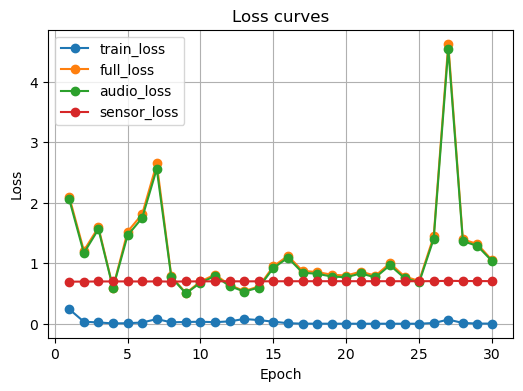

In [54]:
# ===== Loss 曲线：train / full / audio / sensor =====
if not df_main.empty:
    fig, ax = plt.subplots()
    ax.plot(df_main['epoch'], df_main['train_loss'], marker='o', label='train_loss')
    ax.plot(df_main['epoch'], df_main['full_loss'], marker='o', label='full_loss')
    ax.plot(df_main['epoch'], df_main['audio_loss'], marker='o', label='audio_loss')
    ax.plot(df_main['epoch'], df_main['sensor_loss'], marker='o', label='sensor_loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss curves')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print('df_main is empty, cannot plot loss curves.')

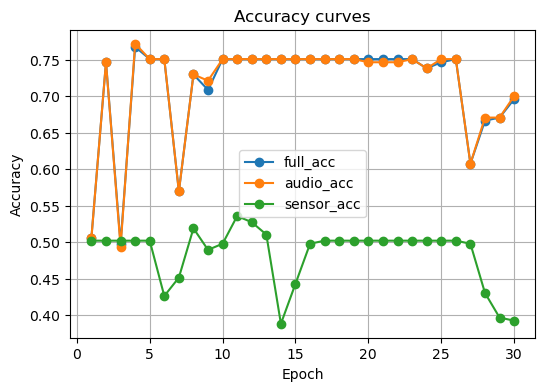

In [55]:
# ===== Accuracy 曲线：full / audio / sensor =====
if not df_main.empty:
    fig, ax = plt.subplots()
    ax.plot(df_main['epoch'], df_main['full_acc'], marker='o', label='full_acc')
    ax.plot(df_main['epoch'], df_main['audio_acc'], marker='o', label='audio_acc')
    ax.plot(df_main['epoch'], df_main['sensor_acc'], marker='o', label='sensor_acc')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy curves')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print('df_main is empty, cannot plot accuracy curves.')

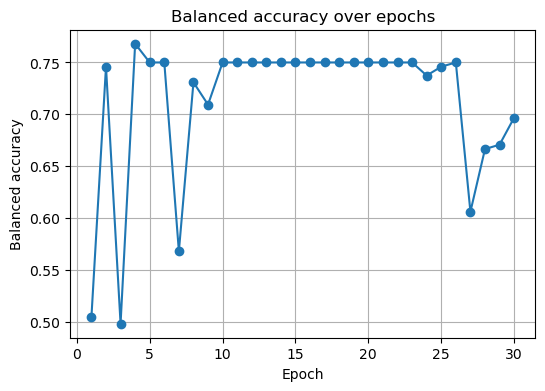

In [56]:
# ===== Balanced accuracy 曲线（基于混淆矩阵） =====
if not df_cm.empty and 'balanced_acc' in df_cm.columns:
    fig, ax = plt.subplots()
    ax.plot(df_cm['epoch'], df_cm['balanced_acc'], marker='o')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Balanced accuracy')
    ax.set_title('Balanced accuracy over epochs')
    ax.grid(True)
    plt.show()
else:
    print('df_cm is empty or balanced_acc not computed, cannot plot.')

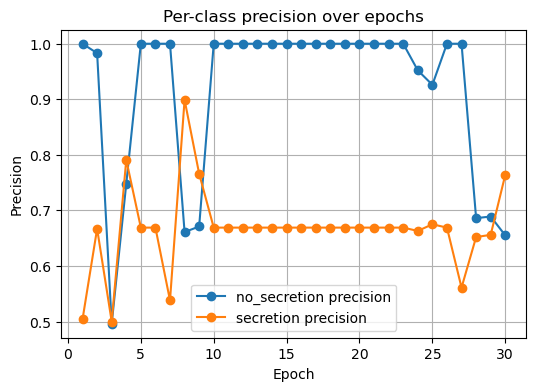

In [57]:
# ===== 每个类别的 precision 曲线 =====
if not df_class.empty:
    fig, ax = plt.subplots()
    for label, group in df_class.groupby('label'):
        ax.plot(group['epoch'], group['precision'], marker='o', label=f'{label} precision')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Precision')
    ax.set_title('Per-class precision over epochs')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print('df_class is empty, cannot plot per-class precision.')

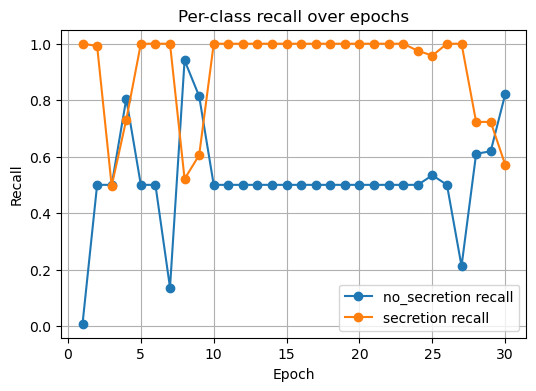

In [58]:
# ===== 每个类别的 recall 曲线 =====
if not df_class.empty:
    fig, ax = plt.subplots()
    for label, group in df_class.groupby('label'):
        ax.plot(group['epoch'], group['recall'], marker='o', label=f'{label} recall')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Recall')
    ax.set_title('Per-class recall over epochs')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print('df_class is empty, cannot plot per-class recall.')

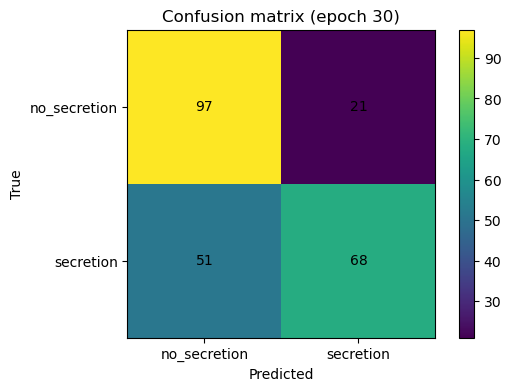

In [59]:
# ===== 最后一个 epoch 的混淆矩阵可视化 =====
if not df_cm.empty:
    last = df_cm.sort_values('epoch').iloc[-1]
    cm = np.array([[last['tn'], last['fp']], [last['fn'], last['tp']]])

    fig, ax = plt.subplots()
    im = ax.imshow(cm)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['no_secretion', 'secretion'])
    ax.set_yticklabels(['no_secretion', 'secretion'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion matrix (epoch {int(last["epoch"])})')

    for i in range(2):
        for j in range(2):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center')

    fig.colorbar(im)
    plt.show()
else:
    print('df_cm is empty, cannot visualize confusion matrix.')

In [60]:
# ===== 最优 epoch 总结（以 full_acc 为准） =====
if not df_main.empty:
    best = df_main.sort_values('full_acc', ascending=False).iloc[0]
    print('Best epoch by full_acc:', int(best['epoch']))
    display(best.to_frame().T)

    if not df_cm.empty:
        cm_best = df_cm[df_cm['epoch'] == int(best['epoch'])]
        if not cm_best.empty:
            print('\nConfusion matrix at best epoch:')
            display(cm_best)
else:
    print('df_main is empty, cannot summarize best epoch.')

Best epoch by full_acc: 4


,epoch,train_loss,full_loss,full_acc,audio_loss,audio_acc,sensor_loss,sensor_acc
3,4.0,0.0057,0.5963,0.7679,0.5907,0.7722,0.6989,0.5021



Confusion matrix at best epoch:


,epoch,tn,fp,fn,tp,acc_from_cm,recall_no,recall_secretion,balanced_acc
3,4,95,23,32,87,0.767932,0.805085,0.731092,0.768089
